# ROC-AUC Analysis for Multi-class Problem

## Prepare data

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
y = iris.target_names[y]

# Adding noise
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

## Fit random forest

In [2]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100, random_state=0)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

## One vs. Rest Approach

> One class is positive, and the rest together are negative

### Convert to one-hot-encoding

In [3]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train) # The fitting process involves learning how many labels are there and their names
y_onehot_test = label_binarizer.transform(y_test) # transform true y labels from the test set
y_onehot_test.shape  # (n_samples, n_classes)

(75, 3)

### Show one class vs. the rest

In [4]:
class_of_interest = "virginica"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0] # np.flatnonzero: show index of non-zero element
class_id

2

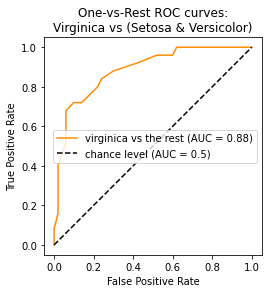

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id], # one-hot encoding of class of interest, 1 means this class is predicted
    y_score[:, class_id], # y score: predicted score from classifier
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

### Micro-averaging

> Better for imbalanced number of classes  
> Micro-averaging aggregates the contributions from all the classes (using np.ravel) to compute the average metrics of the model  
> Total correctness

#### Curve

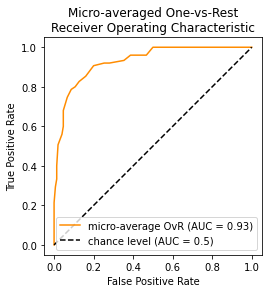

In [6]:
RocCurveDisplay.from_predictions( # From predicted and actual values
    y_onehot_test.ravel(), # np.ravel flattens the array
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [7]:
y_onehot_test.shape

(75, 3)

#### AUC Score

In [8]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro", # Use micro-averaging
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.93


> An equivalent way

In [9]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel()) # Get the false positive rate and true positive rate
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) # Get auc from fpr and tpr

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.93


### Macro-averaging

#### AUC Score

> AUC is calculated for each class, then averaged  
> All classes are treated equally

In [10]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i]) # This will add 3 OvR entries for each class in the fpr and tpr
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000) # shape (1000,) 0 to 1 in 1000 increments

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid) # returns an array of zeros in shape of fpr_grid

# TPR for macro-averaging
for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation, fpr[i] as x coordinates, tpr[i] as y coordinates, interpolate for all fpr values provided by fpr_grid

# Average it and compute AUC
mean_tpr /= n_classes # The previous step summed the tpr for 3 classes, now divide by 3

# roc_curve cannot be used directly to get fpr and tpr for macro-averaging
fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"]) # Compute auc given fpr and tpr

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.91


> This is equivalent to

In [11]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.91


#### Curve

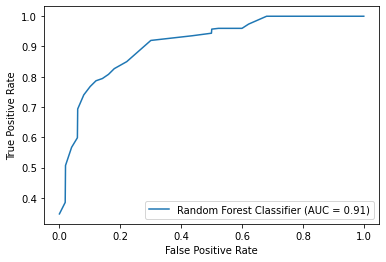

In [12]:
macro_ROC = RocCurveDisplay(fpr=fpr["macro"],tpr=tpr["macro"],roc_auc=roc_auc["macro"],estimator_name="Random Forest Classifier")
macro_ROC.plot()
plt.show()

### Plot all OvR curves

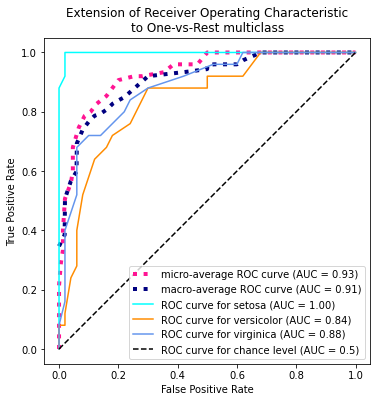

In [13]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

# Micro-averaged Metric
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Macro-averaged Metric
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

# OvR ROC curve for each class
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

## One vs One Approach

> Only macro averaging for OvO approach

### Identify all pairs

In [14]:
from itertools import combinations

pair_list = list(combinations(np.unique(y), 2))
print(pair_list)

[('setosa', 'versicolor'), ('setosa', 'virginica'), ('versicolor', 'virginica')]


### Curve

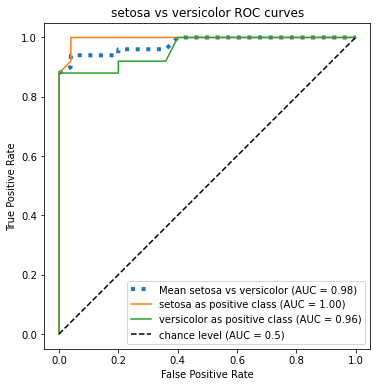

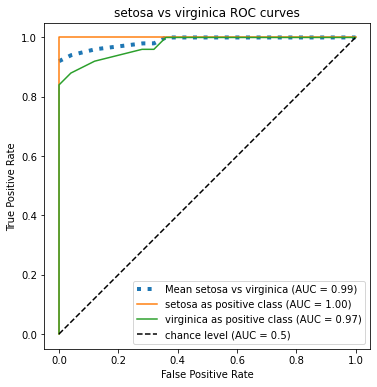

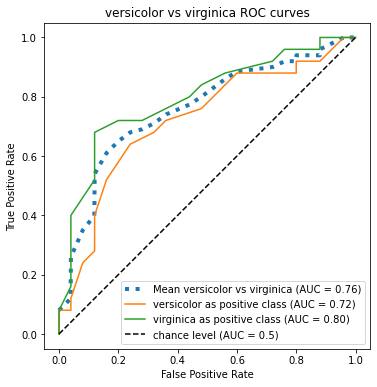

Macro-averaged One-vs-One ROC AUC score:
0.91


In [15]:
pair_scores = []
mean_tpr = dict()

# Iterate through all pairs
for ix, (label_a, label_b) in enumerate(pair_list): # label a: first in the pair, label b: second in the pair

    a_mask = y_test == label_a # All y_tests that are 1 with label a
    b_mask = y_test == label_b # All y_tests that are 1 with label b
    ab_mask = np.logical_or(a_mask, b_mask) # All y_tests that are 1 for either a or b; remove the cases when c is true

    a_true = a_mask[ab_mask] # Remove entries when both a and b are 0
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0] # Index of label a class
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0] # Index of label b class

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a]) # Get fpr and tpr for a
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b]) # Get fpr and tpr for b

    mean_tpr[ix] = np.zeros_like(fpr_grid) # Macro averaging for 2 classes; ix: index for each pair
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score) # Append score for this pair

    fig, ax = plt.subplots(figsize=(6, 6))
    # Macro-averaged score
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    # Label a ROC
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    # Label b ROC
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{target_names[idx_a]} vs {label_b} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

### Macro-averaged AUC

> Averaged over 3 pairs' mean AUC score

In [16]:
macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)

print(f"Macro-averaged One-vs-One ROC AUC score:\n{macro_roc_auc_ovo:.2f}")

Macro-averaged One-vs-One ROC AUC score:
0.91


### Plot all OvO curves

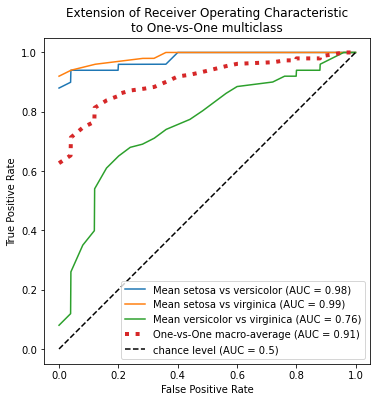

In [17]:
ovo_tpr = np.zeros_like(fpr_grid) # To compute average tpr for all pairs

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix] # Add to ovo_tpr 
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One macro-average (AUC = {macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-One multiclass")
plt.legend()
plt.show()

> The OvO strategy is recommended if the user is mainly interested in correctly identifying a particular class or subset of classes, whereas evaluating the global performance of a classifier can still be summarized via a given averaging strategy.  

> Micro-averaged OvR ROC is dominated by the more frequent class, since the counts are pooled. The macro-averaged alternative better reflects the statistics of the less frequent classes, and then is more appropriate when performance on all the classes is deemed equally important.